# Plant Disease Detection of 'PlantDoc' Dataset, using Tensorflow Object Detection API
- dataset from https://github.com/pratikkayal/PlantDoc-Object-Detection-Dataset
  - original Pascal VOC annotations cleaned up using `./utils/clean-pascalvoc-annotations.ipynb`
- this notebook is referenced from https://github.com/nicknochnack/TFODCourse
- added additional image augmentation preprocessing steps


# 0. Setup Paths

In [1]:
import os
import wget

# CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
# PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
# PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'

# CUSTOM_MODEL_NAME     = 'my_enetd2' 
# PRETRAINED_MODEL_NAME = 'efficientdet_d2_coco17_tpu-32'
# PRETRAINED_MODEL_URL  = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d2_coco17_tpu-32.tar.gz'

CUSTOM_MODEL_NAME     = 'my_resnet101fpn' 
PRETRAINED_MODEL_NAME = 'ssd_resnet101_v1_fpn_640x640_coco17_tpu-8'
PRETRAINED_MODEL_URL  = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz'

TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

paths = {
    'WORKSPACE_PATH':           os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH':             os.path.join('Tensorflow', 'scripts'),
    'APIMODEL_PATH':            os.path.join('Tensorflow', 'models'),
    # 'ANNOTATION_PATH':          os.path.join('Tensorflow', 'workspace','annotations'),
    # 'IMAGE_PATH':               os.path.join('Tensorflow', 'workspace','images'),
    'IMAGE_PATH':               os.path.join('Tensorflow', 'workspace','PlantDoc-Object-Detection-Dataset-master'),
    'ANNOTATION_PATH':          os.path.join('Tensorflow', 'workspace','annotations'),
    
    'MODEL_PATH':               os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH':    os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH':          os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH':              os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':                os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':              os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':              os.path.join('Tensorflow', 'protoc')
}

files = {
    'PIPELINE_CONFIG':  os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP':         os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [2]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Install TFOD API

In [3]:
if os.name=='nt':
    # !pip install wget
    import wget

In [3]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

### Ad-hoc install additional missing packages until TFOD API working

In [ ]:
# !pip install pyyaml
# !pip install pytz
# !pip install --user tensorflow_addons
# !pip install gin-config
# !pip install tf-nightly

### Verify TFOD API working
- as long as the final line says "OK"

In [5]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

Running tests under Python 3.10.4: c:\Anaconda\envs\tfcv\python.exe
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2022-09-19 16:17:30.295196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-19 16:17:30.999543: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6621 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
c:\Anaconda\envs\tfcv\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\builders\model_builder.py:1102: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(('Building experimental DeepMAC meta-arch.'
W091

In [9]:
# import object_detection

### Install & check tf-gpu

In [16]:
tf.__version__

'2.9.0'

In [ ]:
!pip install tensorflow-gpu==2.9.0

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
tf.config.list_physical_devices('GPU')
# tf.test.is_built_with_gpu_support()

# tf.config.set_visible_devices([], 'GPU')
# CUDA_VISIBLE_DEVICES=""

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13030679235253060148
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6592749514
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5742226173955952247
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1.1 Download pre-trained model from TF Model Zoo
- in our case, we are using ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8
- we could download and train multiple models simultaneously, and evaluate trained checkpoints simultaneously to see which model is performing better.

In [3]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

        1 file(s) moved.


x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/checkpoint/
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/checkpoint/checkpoint
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0.index
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/pipeline.config
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/saved_model/
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/saved_model/saved_model.pb
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/saved_model/assets/
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/saved_model/variables/
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x ssd_resnet101_v1_fpn_640x640_coco17_tpu-8/saved_model/variables/variables.index


# 2. Create Label Map

### Manually:

In [ ]:
# labels = [
#     {'id':1, 'name':'axial1', }, 
#     {'id':2, 'name':'axial0', }, 
#     {'id':3, 'name':'coronal1', },
#     {'id':4, 'name':'coronal0', }, 
#     {'id':5, 'name':'sagittal1', }, 
#     {'id':6, 'name':'sagittal0', },
#     ]

### Dataset comes with a csv, so we can use that:

In [4]:
import pandas as pd
train_labels = pd.read_csv(r'D:\code\_projects\_practice\TFODCourse-main\Tensorflow\workspace\PlantDoc-Object-Detection-Dataset-master\train_labels.csv')

In [5]:
classnames = train_labels['class'].unique().tolist()

labels = []
for i, name in enumerate(classnames): 
    labels.append({'id':i+1, 'name':name})

labels

[{'id': 1, 'name': 'Cherry leaf'},
 {'id': 2, 'name': 'Peach leaf'},
 {'id': 3, 'name': 'Corn leaf blight'},
 {'id': 4, 'name': 'Apple rust leaf'},
 {'id': 5, 'name': 'Potato leaf late blight'},
 {'id': 6, 'name': 'Strawberry leaf'},
 {'id': 7, 'name': 'Corn rust leaf'},
 {'id': 8, 'name': 'Tomato leaf late blight'},
 {'id': 9, 'name': 'Tomato mold leaf'},
 {'id': 10, 'name': 'Potato leaf early blight'},
 {'id': 11, 'name': 'Apple leaf'},
 {'id': 12, 'name': 'Tomato leaf yellow virus'},
 {'id': 13, 'name': 'Blueberry leaf'},
 {'id': 14, 'name': 'Tomato leaf mosaic virus'},
 {'id': 15, 'name': 'Raspberry leaf'},
 {'id': 16, 'name': 'Tomato leaf bacterial spot'},
 {'id': 17, 'name': 'Squash Powdery mildew leaf'},
 {'id': 18, 'name': 'grape leaf'},
 {'id': 19, 'name': 'Corn Gray leaf spot'},
 {'id': 20, 'name': 'Tomato Early blight leaf'},
 {'id': 21, 'name': 'Apple Scab Leaf'},
 {'id': 22, 'name': 'Tomato Septoria leaf spot'},
 {'id': 23, 'name': 'Tomato leaf'},
 {'id': 24, 'name': 'Soya

### Save label_map.pbtxt in annotations folder.

In [6]:
with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Generate TF records

In [8]:
#### if need to untar dataset
# ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
# if os.path.exists(ARCHIVE_FILES):
#   !tar -zxvf {ARCHIVE_FILES}

### get generate_tfrecord.py, or download it manually:

In [26]:
# if not os.path.exists(files['TF_RECORD_SCRIPT']):
#     !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}
#     https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py

### run util and generate TFRecords

In [7]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'TRAIN')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')}
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'TEST')}  -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')}


Traceback (most recent call last):
  File "d:\code\_projects\_practice\TFODCourse-main\Tensorflow\scripts\generate_tfrecord.py", line 172, in <module>
    tf.app.run()
  File "c:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\platform\app.py", line 36, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "c:\Anaconda\envs\tfcv\lib\site-packages\absl\app.py", line 308, in run
    _run_main(main, args)
  File "c:\Anaconda\envs\tfcv\lib\site-packages\absl\app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "d:\code\_projects\_practice\TFODCourse-main\Tensorflow\scripts\generate_tfrecord.py", line 162, in main
    tf_example = create_tf_example(group, path)
  File "d:\code\_projects\_practice\TFODCourse-main\Tensorflow\scripts\generate_tfrecord.py", line 116, in create_tf_example
    encoded_jpg = fid.read()
  File "c:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\lib\io\file_io.py", line 114, in read
    self._preread_check()


Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record


# 4. Copy pre-trained model config to our training folder

In [8]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

        1 file(s) copied.


# 5. Customize config for our use case

- https://stackoverflow.com/questions/65768729/how-to-change-data-augmentation-parameters-dynamically-in-the-config-file-of-ten
- https://stackoverflow.com/questions/55323907/dynamically-editing-pipeline-config-for-tensorflow-object-detection
- https://stackoverflow.com/questions/44906317/what-are-possible-values-for-data-augmentation-options-in-the-tensorflow-object


In [9]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format
from object_detection.protos import preprocessor_pb2

In [10]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

In [11]:
# pipeline_config.model.ssd.loss.classification_loss = weighted_softmax
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]


##? ADD IMAGE AUGMENTATION PREPROCESSING STEPS:
# see params here: https://github.com/tensorflow/models/blob/master/research/object_detection/protos/preprocessor.proto

# default copied pipeline config already contains:
#   data_augmentation_options {
#     random_horizontal_flip {
#     }
#   }
#   data_augmentation_options {
#     random_crop_image {
#       min_object_covered: 0.0
#       min_aspect_ratio: 0.75
#       max_aspect_ratio: 3.0
#       min_area: 0.75
#       max_area: 1.0
#       overlap_thresh: 0.0
#     }
#   }

# We will append the following augmentation steps:

augm = preprocessor_pb2.PreprocessingStep()
augm.random_vertical_flip.probability = 0.2
pipeline_config.train_config.data_augmentation_options.append(augm)

augm = preprocessor_pb2.PreprocessingStep()
augm.random_adjust_brightness.max_delta  = 0.2
pipeline_config.train_config.data_augmentation_options.append(augm)

augm = preprocessor_pb2.PreprocessingStep()
augm.random_adjust_contrast.max_delta  = 0.2
pipeline_config.train_config.data_augmentation_options.append(augm)

augm = preprocessor_pb2.PreprocessingStep()
augm.random_rotation90.probability  = 0.5
pipeline_config.train_config.data_augmentation_options.append(augm)



In [12]:
config_text = text_format.MessageToString(pipeline_config)

with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:
    f.write(config_text)

# 6. Train the model

In [15]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=10000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_resnet101fpn --pipeline_config_path=Tensorflow\workspace\models\my_resnet101fpn\pipeline.config --num_train_steps=10000


### Run in CLI (so that we can see the training output) and run results:

In [ ]:
"""
Step 100 per-step time 1.434s
I0927 20:11:40.496810 23472 model_lib_v2.py:705] Step 100 per-step time 1.434s
{'Loss/classification_loss': 1.0384237,
 'Loss/localization_loss': 0.70474374,
 'Loss/regularization_loss': 0.30255803,
 'Loss/total_loss': 2.0457253,
 'learning_rate': 0.014666351}

Step 200 per-step time 1.094s
I0927 20:13:29.290310 23472 model_lib_v2.py:705] Step 200 per-step time 1.094s
{'Loss/classification_loss': 0.8809481,
 'Loss/localization_loss': 0.5801564,
 'Loss/regularization_loss': 0.32176465,
 'Loss/total_loss': 1.7828691,
 'learning_rate': 0.0159997}

Step 300 per-step time 1.360s
I0927 20:15:45.256810 23472 model_lib_v2.py:705] Step 300 per-step time 1.360s
{'Loss/classification_loss': 0.9167367,
 'Loss/localization_loss': 0.6573277,
 'Loss/regularization_loss': 0.32173863,
 'Loss/total_loss': 1.895803,
 'learning_rate': 0.01733305}

Step 400 per-step time 1.094s
I0927 20:17:34.720810 23472 model_lib_v2.py:705] Step 400 per-step time 1.094s
{'Loss/classification_loss': 0.8273007,
 'Loss/localization_loss': 0.458481,
 'Loss/regularization_loss': 0.32207838,
 'Loss/total_loss': 1.6078601,
 'learning_rate': 0.0186664}

Step 500 per-step time 2.182s
I0927 20:21:13.280810 23472 model_lib_v2.py:705] Step 500 per-step time 2.182s
{'Loss/classification_loss': 0.9383586,
 'Loss/localization_loss': 0.577653,
 'Loss/regularization_loss': 0.32321867,
 'Loss/total_loss': 1.8392303,
 'learning_rate': 0.01999975}

Step 600 per-step time 1.114s
I0927 20:23:04.289310 23472 model_lib_v2.py:705] Step 600 per-step time 1.114s
{'Loss/classification_loss': 1.0107393,
 'Loss/localization_loss': 0.4757303,
 'Loss/regularization_loss': 0.32316488,
 'Loss/total_loss': 1.8096346,
 'learning_rate': 0.0213331}

Step 700 per-step time 1.287s
I0927 20:25:13.248810 23472 model_lib_v2.py:705] Step 700 per-step time 1.287s
{'Loss/classification_loss': 0.8958652,
 'Loss/localization_loss': 0.44558436,
 'Loss/regularization_loss': 0.32380742,
 'Loss/total_loss': 1.665257,
 'learning_rate': 0.02266645}

Step 800 per-step time 1.106s
I0927 20:27:04.340310 23472 model_lib_v2.py:705] Step 800 per-step time 1.106s
{'Loss/classification_loss': 0.7712467,
 'Loss/localization_loss': 0.54805994,
 'Loss/regularization_loss': 0.32367423,
 'Loss/total_loss': 1.6429808,
 'learning_rate': 0.023999799}

Step 900 per-step time 1.120s
I0927 20:28:55.550810 23472 model_lib_v2.py:705] Step 900 per-step time 1.120s
{'Loss/classification_loss': 0.83285356,
 'Loss/localization_loss': 0.5217503,
 'Loss/regularization_loss': 0.32980728,
 'Loss/total_loss': 1.684411,
 'learning_rate': 0.025333151}

Step 1000 per-step time 1.094s
I0927 20:30:44.942810 23472 model_lib_v2.py:705] Step 1000 per-step time 1.094s
{'Loss/classification_loss': 0.7363528,
 'Loss/localization_loss': 0.42519844,
 'Loss/regularization_loss': 0.34201315,
 'Loss/total_loss': 1.5035644,
 'learning_rate': 0.0266665}

Step 1100 per-step time 1.171s
I0927 20:32:42.568310 23472 model_lib_v2.py:705] Step 1100 per-step time 1.171s
{'Loss/classification_loss': 0.86153126,
 'Loss/localization_loss': 0.40888023,
 'Loss/regularization_loss': 0.33975905,
 'Loss/total_loss': 1.6101706,
 'learning_rate': 0.02799985}

Step 1200 per-step time 1.125s
I0927 20:34:34.594310 23472 model_lib_v2.py:705] Step 1200 per-step time 1.125s
{'Loss/classification_loss': 0.8975738,
 'Loss/localization_loss': 0.34687737,
 'Loss/regularization_loss': 0.3368633,
 'Loss/total_loss': 1.5813144,
 'learning_rate': 0.0293332}

Step 1300 per-step time 1.106s
I0927 20:36:25.612809 23472 model_lib_v2.py:705] Step 1300 per-step time 1.106s
{'Loss/classification_loss': 0.7893705,
 'Loss/localization_loss': 0.45749247,
 'Loss/regularization_loss': 0.3341611,
 'Loss/total_loss': 1.581024,
 'learning_rate': 0.03066655}

Step 1400 per-step time 1.093s
I0927 20:38:15.718811 23472 model_lib_v2.py:705] Step 1400 per-step time 1.093s
{'Loss/classification_loss': 0.95477265,
 'Loss/localization_loss': 0.47159836,
 'Loss/regularization_loss': 0.3313049,
 'Loss/total_loss': 1.7576759,
 'learning_rate': 0.0319999}

Step 1500 per-step time 1.116s
I0927 20:40:06.025309 23472 model_lib_v2.py:705] Step 1500 per-step time 1.116s
{'Loss/classification_loss': 0.6995255,
 'Loss/localization_loss': 0.38122544,
 'Loss/regularization_loss': 0.32792002,
 'Loss/total_loss': 1.408671,
 'learning_rate': 0.03333325}

Step 1600 per-step time 1.143s
I0927 20:42:00.345810 23472 model_lib_v2.py:705] Step 1600 per-step time 1.143s
{'Loss/classification_loss': 0.7919326,
 'Loss/localization_loss': 0.46362013,
 'Loss/regularization_loss': 0.327406,
 'Loss/total_loss': 1.5829587,
 'learning_rate': 0.034666598}

Step 1700 per-step time 1.120s
I0927 20:43:52.417312 23472 model_lib_v2.py:705] Step 1700 per-step time 1.120s
{'Loss/classification_loss': 0.765319,
 'Loss/localization_loss': 0.4304216,
 'Loss/regularization_loss': 0.32348472,
 'Loss/total_loss': 1.5192254,
 'learning_rate': 0.03599995}

Step 1800 per-step time 1.121s
I0927 20:45:44.468810 23472 model_lib_v2.py:705] Step 1800 per-step time 1.121s
{'Loss/classification_loss': 1.0113807,
 'Loss/localization_loss': 0.54445994,
 'Loss/regularization_loss': 0.32114014,
 'Loss/total_loss': 1.8769808,
 'learning_rate': 0.037333302}

Step 1900 per-step time 1.126s
I0927 20:47:37.957810 23472 model_lib_v2.py:705] Step 1900 per-step time 1.126s
{'Loss/classification_loss': 0.7750811,
 'Loss/localization_loss': 0.33383673,
 'Loss/regularization_loss': 0.3270827,
 'Loss/total_loss': 1.4360006,
 'learning_rate': 0.03866665}

Step 2000 per-step time 1.134s
I0927 20:49:30.849310 23472 model_lib_v2.py:705] Step 2000 per-step time 1.134s
{'Loss/classification_loss': 0.71132493,
 'Loss/localization_loss': 0.3780533,
 'Loss/regularization_loss': 0.32985762,
 'Loss/total_loss': 1.4192358,
 'learning_rate': 0.04}

Step 2100 per-step time 1.153s
I0927 20:51:25.757310 23472 model_lib_v2.py:705] Step 2100 per-step time 1.153s
{'Loss/classification_loss': 0.7992082,
 'Loss/localization_loss': 0.43017733,
 'Loss/regularization_loss': 0.3282311,
 'Loss/total_loss': 1.5576166,
 'learning_rate': 0.039998136}

Step 2200 per-step time 1.137s
I0927 20:53:19.929310 23472 model_lib_v2.py:705] Step 2200 per-step time 1.137s
{'Loss/classification_loss': 0.8743149,
 'Loss/localization_loss': 0.5183432,
 'Loss/regularization_loss': 0.32448167,
 'Loss/total_loss': 1.7171397,
 'learning_rate': 0.039992537}

Step 2300 per-step time 1.145s
I0927 20:55:13.989310 23472 model_lib_v2.py:705] Step 2300 per-step time 1.145s
{'Loss/classification_loss': 0.6946781,
 'Loss/localization_loss': 0.37124205,
 'Loss/regularization_loss': 0.35480526,
 'Loss/total_loss': 1.4207255,
 'learning_rate': 0.03998321}

Step 2400 per-step time 1.140s
I0927 20:57:08.016310 23472 model_lib_v2.py:705] Step 2400 per-step time 1.140s
{'Loss/classification_loss': 0.6664141,
 'Loss/localization_loss': 0.44658136,
 'Loss/regularization_loss': 0.35041732,
 'Loss/total_loss': 1.4634128,
 'learning_rate': 0.039970152}

Step 2500 per-step time 1.133s
I0927 20:59:01.821310 23472 model_lib_v2.py:705] Step 2500 per-step time 1.133s
{'Loss/classification_loss': 0.774568,
 'Loss/localization_loss': 0.45755196,
 'Loss/regularization_loss': 0.34726626,
 'Loss/total_loss': 1.5793862,
 'learning_rate': 0.039953373}

Step 2600 per-step time 1.126s
I0927 21:00:54.297315 23472 model_lib_v2.py:705] Step 2600 per-step time 1.126s
{'Loss/classification_loss': 0.7122256,
 'Loss/localization_loss': 0.458468,
 'Loss/regularization_loss': 0.34357944,
 'Loss/total_loss': 1.514273,
 'learning_rate': 0.03993287}

Step 2700 per-step time 1.142s
I0927 21:02:48.130310 23472 model_lib_v2.py:705] Step 2700 per-step time 1.142s
{'Loss/classification_loss': 0.8254436,
 'Loss/localization_loss': 0.33946094,
 'Loss/regularization_loss': 0.33844778,
 'Loss/total_loss': 1.5033524,
 'learning_rate': 0.039908648}

Step 2800 per-step time 1.139s
I0927 21:04:42.009810 23472 model_lib_v2.py:705] Step 2800 per-step time 1.139s
{'Loss/classification_loss': 0.7410682,
 'Loss/localization_loss': 0.4564964,
 'Loss/regularization_loss': 0.33302823,
 'Loss/total_loss': 1.5305928,
 'learning_rate': 0.039880715}

Step 2900 per-step time 1.136s
I0927 21:06:35.652810 23472 model_lib_v2.py:705] Step 2900 per-step time 1.136s
{'Loss/classification_loss': 0.75317985,
 'Loss/localization_loss': 0.44159392,
 'Loss/regularization_loss': 0.32879147,
 'Loss/total_loss': 1.5235652,
 'learning_rate': 0.039849065}

Step 3000 per-step time 1.126s
I0927 21:08:28.282810 23472 model_lib_v2.py:705] Step 3000 per-step time 1.126s
{'Loss/classification_loss': 0.85608685,
 'Loss/localization_loss': 0.5492266,
 'Loss/regularization_loss': 0.32489365,
 'Loss/total_loss': 1.730207,
 'learning_rate': 0.03981372}

Step 3100 per-step time 1.146s
I0927 21:10:23.429810 23472 model_lib_v2.py:705] Step 3100 per-step time 1.146s
{'Loss/classification_loss': 0.8347985,
 'Loss/localization_loss': 0.5081695,
 'Loss/regularization_loss': 0.3308104,
 'Loss/total_loss': 1.6737783,
 'learning_rate': 0.03977467}

Step 3200 per-step time 1.108s
I0927 21:12:13.694810 23472 model_lib_v2.py:705] Step 3200 per-step time 1.108s
{'Loss/classification_loss': 0.6959103,
 'Loss/localization_loss': 0.43682653,
 'Loss/regularization_loss': 0.35960975,
 'Loss/total_loss': 1.4923465,
 'learning_rate': 0.03973194}

Step 3300 per-step time 1.127s
I0927 21:14:06.349810 23472 model_lib_v2.py:705] Step 3300 per-step time 1.127s
{'Loss/classification_loss': 0.7728983,
 'Loss/localization_loss': 0.4463582,
 'Loss/regularization_loss': 0.35490844,
 'Loss/total_loss': 1.574165,
 'learning_rate': 0.03968552}

Step 3400 per-step time 1.127s
I0927 21:15:59.027310 23472 model_lib_v2.py:705] Step 3400 per-step time 1.127s
{'Loss/classification_loss': 0.6621922,
 'Loss/localization_loss': 0.45530134,
 'Loss/regularization_loss': 0.3487368,
 'Loss/total_loss': 1.4662304,
 'learning_rate': 0.039635435}

Step 3500 per-step time 1.102s
I0927 21:17:49.192309 23472 model_lib_v2.py:705] Step 3500 per-step time 1.102s
{'Loss/classification_loss': 0.69334465,
 'Loss/localization_loss': 0.31993905,
 'Loss/regularization_loss': 0.34148443,
 'Loss/total_loss': 1.3547682,
 'learning_rate': 0.03958168}

Step 3600 per-step time 1.103s
I0927 21:19:39.428310 23472 model_lib_v2.py:705] Step 3600 per-step time 1.103s
{'Loss/classification_loss': 0.77251077,
 'Loss/localization_loss': 0.3659093,
 'Loss/regularization_loss': 0.34677634,
 'Loss/total_loss': 1.4851965,
 'learning_rate': 0.039524276}

Step 3700 per-step time 1.112s
I0927 21:21:30.981810 23472 model_lib_v2.py:705] Step 3700 per-step time 1.112s
{'Loss/classification_loss': 0.7519587,
 'Loss/localization_loss': 0.35689712,
 'Loss/regularization_loss': 0.34087408,
 'Loss/total_loss': 1.4497299,
 'learning_rate': 0.03946323}

Step 3800 per-step time 1.142s
I0927 21:23:24.895310 23472 model_lib_v2.py:705] Step 3800 per-step time 1.142s
{'Loss/classification_loss': 0.7813569,
 'Loss/localization_loss': 0.47100794,
 'Loss/regularization_loss': 0.3341636,
 'Loss/total_loss': 1.5865284,
 'learning_rate': 0.039398547}

Step 3900 per-step time 173.226s
I0928 02:12:07.521719 23472 model_lib_v2.py:705] Step 3900 per-step time 173.226s
{'Loss/classification_loss': 0.7358896,
 'Loss/localization_loss': 0.54166156,
 'Loss/regularization_loss': 0.32762197,
 'Loss/total_loss': 1.6051731,
 'learning_rate': 0.039330248}

Step 4000 per-step time 1.114s
I0928 02:13:59.049218 23472 model_lib_v2.py:705] Step 4000 per-step time 1.114s
{'Loss/classification_loss': 0.61938685,
 'Loss/localization_loss': 0.12331976,
 'Loss/regularization_loss': 0.32317144,
 'Loss/total_loss': 1.065878,
 'learning_rate': 0.039258346}

Step 4100 per-step time 1.145s
I0928 02:15:53.536221 23472 model_lib_v2.py:705] Step 4100 per-step time 1.145s
{'Loss/classification_loss': 0.6208104,
 'Loss/localization_loss': 0.18370236,
 'Loss/regularization_loss': 0.31799105,
 'Loss/total_loss': 1.1225038,
 'learning_rate': 0.03918285}

Step 4200 per-step time 1.116s
I0928 02:17:45.067717 23472 model_lib_v2.py:705] Step 4200 per-step time 1.116s
{'Loss/classification_loss': 0.68005204,
 'Loss/localization_loss': 0.36696473,
 'Loss/regularization_loss': 0.31207013,
 'Loss/total_loss': 1.3590869,
 'learning_rate': 0.03910377}

Step 4300 per-step time 1.112s
I0928 02:19:36.285717 23472 model_lib_v2.py:705] Step 4300 per-step time 1.112s
{'Loss/classification_loss': 0.7006114,
 'Loss/localization_loss': 0.51168156,
 'Loss/regularization_loss': 0.30646932,
 'Loss/total_loss': 1.5187624,
 'learning_rate': 0.039021127}

Step 4400 per-step time 1.114s
I0928 02:21:28.093719 23472 model_lib_v2.py:705] Step 4400 per-step time 1.114s
{'Loss/classification_loss': 0.7291656,
 'Loss/localization_loss': 0.2849308,
 'Loss/regularization_loss': 0.30262923,
 'Loss/total_loss': 1.3167256,
 'learning_rate': 0.03893494}

Step 4500 per-step time 1.119s
I0928 02:23:19.594717 23472 model_lib_v2.py:705] Step 4500 per-step time 1.119s
{'Loss/classification_loss': 0.6190657,
 'Loss/localization_loss': 0.30627704,
 'Loss/regularization_loss': 0.29919368,
 'Loss/total_loss': 1.2245364,
 'learning_rate': 0.03884522}

Step 4600 per-step time 1.115s
I0928 02:25:11.066717 23472 model_lib_v2.py:705] Step 4600 per-step time 1.115s
{'Loss/classification_loss': 0.7091758,
 'Loss/localization_loss': 0.2808136,
 'Loss/regularization_loss': 0.2960799,
 'Loss/total_loss': 1.2860693,
 'learning_rate': 0.03875198}

Step 4700 per-step time 1.114s
I0928 02:27:02.760219 23472 model_lib_v2.py:705] Step 4700 per-step time 1.114s
{'Loss/classification_loss': 0.74652535,
 'Loss/localization_loss': 0.40424204,
 'Loss/regularization_loss': 0.29233724,
 'Loss/total_loss': 1.4431046,
 'learning_rate': 0.038655244}

Step 4800 per-step time 1.117s
I0928 02:28:54.124719 23472 model_lib_v2.py:705] Step 4800 per-step time 1.117s
{'Loss/classification_loss': 0.8379751,
 'Loss/localization_loss': 0.56625116,
 'Loss/regularization_loss': 0.29055747,
 'Loss/total_loss': 1.6947837,
 'learning_rate': 0.038555026}

Step 4900 per-step time 1.113s
I0928 02:30:45.401217 23472 model_lib_v2.py:705] Step 4900 per-step time 1.113s
{'Loss/classification_loss': 0.74250895,
 'Loss/localization_loss': 0.29874304,
 'Loss/regularization_loss': 0.28673953,
 'Loss/total_loss': 1.3279915,
 'learning_rate': 0.038451348}

Step 5000 per-step time 1.110s
I0928 02:32:36.444218 23472 model_lib_v2.py:705] Step 5000 per-step time 1.110s
{'Loss/classification_loss': 0.71902335,
 'Loss/localization_loss': 0.47652173,
 'Loss/regularization_loss': 0.28373945,
 'Loss/total_loss': 1.4792845,
 'learning_rate': 0.038344227}

Step 5100 per-step time 1.140s
I0928 02:34:30.474217 23472 model_lib_v2.py:705] Step 5100 per-step time 1.140s
{'Loss/classification_loss': 0.7369177,
 'Loss/localization_loss': 0.52231014,
 'Loss/regularization_loss': 0.2842218,
 'Loss/total_loss': 1.5434496,
 'learning_rate': 0.03823368}

Step 5200 per-step time 1.113s
I0928 02:36:22.839718 23472 model_lib_v2.py:705] Step 5200 per-step time 1.113s
{'Loss/classification_loss': 0.69862527,
 'Loss/localization_loss': 0.4580544,
 'Loss/regularization_loss': 0.2792673,
 'Loss/total_loss': 1.435947,
 'learning_rate': 0.038119733}

Step 5300 per-step time 1.122s
I0928 02:38:13.929718 23472 model_lib_v2.py:705] Step 5300 per-step time 1.122s
{'Loss/classification_loss': 0.8441701,
 'Loss/localization_loss': 0.3965174,
 'Loss/regularization_loss': 0.27460587,
 'Loss/total_loss': 1.5152934,
 'learning_rate': 0.03800241}

Step 5400 per-step time 1.115s
I0928 02:40:05.435717 23472 model_lib_v2.py:705] Step 5400 per-step time 1.115s
{'Loss/classification_loss': 0.7097857,
 'Loss/localization_loss': 0.23186657,
 'Loss/regularization_loss': 0.26983866,
 'Loss/total_loss': 1.211491,
 'learning_rate': 0.037881725}

Step 5500 per-step time 1.112s
I0928 02:41:56.632717 23472 model_lib_v2.py:705] Step 5500 per-step time 1.112s
{'Loss/classification_loss': 0.7017019,
 'Loss/localization_loss': 0.4841258,
 'Loss/regularization_loss': 0.26601616,
 'Loss/total_loss': 1.4518437,
 'learning_rate': 0.037757702}

Step 5600 per-step time 1.112s
I0928 02:43:48.212720 23472 model_lib_v2.py:705] Step 5600 per-step time 1.112s
{'Loss/classification_loss': 0.85356116,
 'Loss/localization_loss': 0.40678275,
 'Loss/regularization_loss': 0.26271003,
 'Loss/total_loss': 1.523054,
 'learning_rate': 0.03763037}

Step 5700 per-step time 1.114s
I0928 02:45:39.266717 23472 model_lib_v2.py:705] Step 5700 per-step time 1.114s
{'Loss/classification_loss': 0.61664236,
 'Loss/localization_loss': 0.34449637,
 'Loss/regularization_loss': 0.26090527,
 'Loss/total_loss': 1.222044,
 'learning_rate': 0.03749975}

Step 5800 per-step time 1.112s
I0928 02:47:30.571219 23472 model_lib_v2.py:705] Step 5800 per-step time 1.112s
{'Loss/classification_loss': 0.5747915,
 'Loss/localization_loss': 0.2804217,
 'Loss/regularization_loss': 0.2582905,
 'Loss/total_loss': 1.1135037,
 'learning_rate': 0.037365858}

Step 5900 per-step time 1.112s
I0928 02:49:21.733718 23472 model_lib_v2.py:705] Step 5900 per-step time 1.112s
{'Loss/classification_loss': 0.6765669,
 'Loss/localization_loss': 0.2833761,
 'Loss/regularization_loss': 0.25451466,
 'Loss/total_loss': 1.2144576,
 'learning_rate': 0.03722873}

Step 6000 per-step time 1.114s
I0928 02:51:13.093717 23472 model_lib_v2.py:705] Step 6000 per-step time 1.114s
{'Loss/classification_loss': 0.725247,
 'Loss/localization_loss': 0.37268007,
 'Loss/regularization_loss': 0.25094217,
 'Loss/total_loss': 1.3488693,
 'learning_rate': 0.037088387}

Step 6100 per-step time 1.140s
I0928 02:53:07.436717 23472 model_lib_v2.py:705] Step 6100 per-step time 1.140s
{'Loss/classification_loss': 0.80137646,
 'Loss/localization_loss': 0.31797087,
 'Loss/regularization_loss': 0.24921876,
 'Loss/total_loss': 1.3685662,
 'learning_rate': 0.036944855}

Step 6200 per-step time 1.113s
I0928 02:54:58.830722 23472 model_lib_v2.py:705] Step 6200 per-step time 1.113s
{'Loss/classification_loss': 0.8234809,
 'Loss/localization_loss': 0.45047382,
 'Loss/regularization_loss': 0.24735244,
 'Loss/total_loss': 1.5213071,
 'learning_rate': 0.036798168}

Step 6300 per-step time 1.116s
I0928 02:56:50.018218 23472 model_lib_v2.py:705] Step 6300 per-step time 1.116s
{'Loss/classification_loss': 0.80835164,
 'Loss/localization_loss': 0.5886123,
 'Loss/regularization_loss': 0.25156036,
 'Loss/total_loss': 1.6485243,
 'learning_rate': 0.03664834}

Step 6400 per-step time 1.115s
I0928 02:58:41.913221 23472 model_lib_v2.py:705] Step 6400 per-step time 1.115s
{'Loss/classification_loss': 0.70009214,
 'Loss/localization_loss': 0.43273667,
 'Loss/regularization_loss': 0.25057366,
 'Loss/total_loss': 1.3834025,
 'learning_rate': 0.03649541}

Step 6500 per-step time 1.119s
I0928 03:00:33.433719 23472 model_lib_v2.py:705] Step 6500 per-step time 1.119s
{'Loss/classification_loss': 0.71519905,
 'Loss/localization_loss': 0.3929846,
 'Loss/regularization_loss': 0.24741533,
 'Loss/total_loss': 1.355599,
 'learning_rate': 0.0363394}

Step 6600 per-step time 1.115s
I0928 03:02:24.834218 23472 model_lib_v2.py:705] Step 6600 per-step time 1.115s
{'Loss/classification_loss': 0.7245417,
 'Loss/localization_loss': 0.37681514,
 'Loss/regularization_loss': 0.244279,
 'Loss/total_loss': 1.3456359,
 'learning_rate': 0.03618034}

Step 6700 per-step time 1.113s
I0928 03:04:16.927718 23472 model_lib_v2.py:705] Step 6700 per-step time 1.113s
{'Loss/classification_loss': 0.8911117,
 'Loss/localization_loss': 0.57969147,
 'Loss/regularization_loss': 0.24071595,
 'Loss/total_loss': 1.711519,
 'learning_rate': 0.03601826}

Step 6800 per-step time 1.120s
I0928 03:06:08.558719 23472 model_lib_v2.py:705] Step 6800 per-step time 1.120s
{'Loss/classification_loss': 0.63075066,
 'Loss/localization_loss': 0.17552996,
 'Loss/regularization_loss': 0.23719123,
 'Loss/total_loss': 1.0434718,
 'learning_rate': 0.035853196}

Step 6900 per-step time 1.131s
I0928 03:08:01.206717 23472 model_lib_v2.py:705] Step 6900 per-step time 1.131s
{'Loss/classification_loss': 0.66232586,
 'Loss/localization_loss': 0.17708617,
 'Loss/regularization_loss': 0.23435123,
 'Loss/total_loss': 1.0737633,
 'learning_rate': 0.035685178}



### ACCIDENTALLY QUIT, RESUMED AGAIN:



Step 6100 per-step time 1.552s
I0928 03:15:03.824720 15336 model_lib_v2.py:705] Step 6100 per-step time 1.552s
{'Loss/classification_loss': 0.92651534,
 'Loss/localization_loss': 0.40249085,
 'Loss/regularization_loss': 0.2490721,
 'Loss/total_loss': 1.5780783,
 'learning_rate': 0.036944855}

Step 6200 per-step time 1.198s
I0928 03:17:01.915219 15336 model_lib_v2.py:705] Step 6200 per-step time 1.198s
{'Loss/classification_loss': 0.6563401,
 'Loss/localization_loss': 0.28509822,
 'Loss/regularization_loss': 0.24603938,
 'Loss/total_loss': 1.1874777,
 'learning_rate': 0.036798168}

Step 6300 per-step time 1.210s
I0928 03:19:02.874720 15336 model_lib_v2.py:705] Step 6300 per-step time 1.210s
{'Loss/classification_loss': 0.70194805,
 'Loss/localization_loss': 0.40418184,
 'Loss/regularization_loss': 0.24262264,
 'Loss/total_loss': 1.3487525,
 'learning_rate': 0.03664834}

Step 6400 per-step time 1.182s
I0928 03:21:01.532718 15336 model_lib_v2.py:705] Step 6400 per-step time 1.182s
{'Loss/classification_loss': 0.8058178,
 'Loss/localization_loss': 0.3745164,
 'Loss/regularization_loss': 0.24101807,
 'Loss/total_loss': 1.4213523,
 'learning_rate': 0.03649541}

Step 6500 per-step time 1.194s
I0928 03:23:00.486217 15336 model_lib_v2.py:705] Step 6500 per-step time 1.194s
{'Loss/classification_loss': 0.8319223,
 'Loss/localization_loss': 0.48734242,
 'Loss/regularization_loss': 0.23780736,
 'Loss/total_loss': 1.5570722,
 'learning_rate': 0.0363394}

Step 6600 per-step time 1.181s
I0928 03:24:59.444718 15336 model_lib_v2.py:705] Step 6600 per-step time 1.181s
{'Loss/classification_loss': 0.8971221,
 'Loss/localization_loss': 0.45099065,
 'Loss/regularization_loss': 0.23503548,
 'Loss/total_loss': 1.5831482,
 'learning_rate': 0.03618034}

Step 6700 per-step time 1.161s
I0928 03:26:54.734718 15336 model_lib_v2.py:705] Step 6700 per-step time 1.161s
{'Loss/classification_loss': 0.7361085,
 'Loss/localization_loss': 0.3566511,
 'Loss/regularization_loss': 0.23256287,
 'Loss/total_loss': 1.3253224,
 'learning_rate': 0.03601826}

Step 6800 per-step time 1.172s
I0928 03:28:51.910217 15336 model_lib_v2.py:705] Step 6800 per-step time 1.172s
{'Loss/classification_loss': 0.67408234,
 'Loss/localization_loss': 0.4685464,
 'Loss/regularization_loss': 0.23102298,
 'Loss/total_loss': 1.3736517,
 'learning_rate': 0.035853196}

Step 6900 per-step time 1.150s
I0928 03:30:47.271218 15336 model_lib_v2.py:705] Step 6900 per-step time 1.150s
{'Loss/classification_loss': 0.6425356,
 'Loss/localization_loss': 0.4355637,
 'Loss/regularization_loss': 0.23026994,
 'Loss/total_loss': 1.3083693,
 'learning_rate': 0.035685178}

Step 7000 per-step time 1.152s
I0928 03:32:42.152218 15336 model_lib_v2.py:705] Step 7000 per-step time 1.152s
{'Loss/classification_loss': 0.64436835,
 'Loss/localization_loss': 0.22489187,
 'Loss/regularization_loss': 0.2277897,
 'Loss/total_loss': 1.09705,
 'learning_rate': 0.035514224}



I0928 03:34:39.169719 15336 model_lib_v2.py:705] Step 7100 per-step time 1.170s
{'Loss/classification_loss': 0.60889125,
 'Loss/localization_loss': 0.29832247,
 'Loss/regularization_loss': 0.2258003,
 'Loss/total_loss': 1.133014,
 'learning_rate': 0.035340384}

Step 7200 per-step time 1.148s
I0928 03:36:34.956219 15336 model_lib_v2.py:705] Step 7200 per-step time 1.148s
{'Loss/classification_loss': 0.6959901,
 'Loss/localization_loss': 0.40044641,
 'Loss/regularization_loss': 0.22364317,
 'Loss/total_loss': 1.3200797,
 'learning_rate': 0.035163675}

Step 7300 per-step time 1.157s
I0928 03:38:30.458219 15336 model_lib_v2.py:705] Step 7300 per-step time 1.157s
{'Loss/classification_loss': 0.74038696,
 'Loss/localization_loss': 0.3595088,
 'Loss/regularization_loss': 0.2208502,
 'Loss/total_loss': 1.320746,
 'learning_rate': 0.034984138}

Step 7400 per-step time 1.157s
I0928 03:40:25.411718 15336 model_lib_v2.py:705] Step 7400 per-step time 1.157s
{'Loss/classification_loss': 0.6181128,
 'Loss/localization_loss': 0.1301788,
 'Loss/regularization_loss': 0.21860805,
 'Loss/total_loss': 0.96689963,
 'learning_rate': 0.03480181}

Step 7500 per-step time 1.150s
I0928 03:42:20.419217 15336 model_lib_v2.py:705] Step 7500 per-step time 1.150s
{'Loss/classification_loss': 0.7380044,
 'Loss/localization_loss': 0.43570033,
 'Loss/regularization_loss': 0.21639249,
 'Loss/total_loss': 1.3900971,
 'learning_rate': 0.034616716}

Step 7600 per-step time 1.150s
I0928 03:44:15.445718 15336 model_lib_v2.py:705] Step 7600 per-step time 1.150s
{'Loss/classification_loss': 0.61969864,
 'Loss/localization_loss': 0.33376515,
 'Loss/regularization_loss': 0.21480016,
 'Loss/total_loss': 1.1682639,
 'learning_rate': 0.0344289}

Step 7700 per-step time 1.149s
I0928 03:46:10.276718 15336 model_lib_v2.py:705] Step 7700 per-step time 1.149s
{'Loss/classification_loss': 0.73014915,
 'Loss/localization_loss': 0.31744787,
 'Loss/regularization_loss': 0.21478155,
 'Loss/total_loss': 1.2623786,
 'learning_rate': 0.03423839}

Step 7800 per-step time 1.146s
I0928 03:48:05.391218 15336 model_lib_v2.py:705] Step 7800 per-step time 1.146s
{'Loss/classification_loss': 0.7455366,
 'Loss/localization_loss': 0.2352146,
 'Loss/regularization_loss': 0.2139758,
 'Loss/total_loss': 1.1947271,
 'learning_rate': 0.03404522}

Step 7900 per-step time 1.152s
I0928 03:50:01.260218 15336 model_lib_v2.py:705] Step 7900 per-step time 1.152s
{'Loss/classification_loss': 0.6997795,
 'Loss/localization_loss': 0.32223722,
 'Loss/regularization_loss': 0.21224229,
 'Loss/total_loss': 1.234259,
 'learning_rate': 0.033849433}

Step 8000 per-step time 1.162s
I0928 03:51:56.217219 15336 model_lib_v2.py:705] Step 8000 per-step time 1.162s
{'Loss/classification_loss': 0.6195105,
 'Loss/localization_loss': 0.2791945,
 'Loss/regularization_loss': 0.21317275,
 'Loss/total_loss': 1.1118777,
 'learning_rate': 0.03365106}

Step 8100 per-step time 1.179s
I0928 03:53:54.108718 15336 model_lib_v2.py:705] Step 8100 per-step time 1.179s
{'Loss/classification_loss': 0.70683426,
 'Loss/localization_loss': 0.4553275,
 'Loss/regularization_loss': 0.21262887,
 'Loss/total_loss': 1.3747907,
 'learning_rate': 0.033450145}

Step 8200 per-step time 1.148s
I0928 03:55:48.880218 15336 model_lib_v2.py:705] Step 8200 per-step time 1.148s
{'Loss/classification_loss': 0.67908454,
 'Loss/localization_loss': 0.3312786,
 'Loss/regularization_loss': 0.21089771,
 'Loss/total_loss': 1.2212608,
 'learning_rate': 0.03324672}

Step 8300 per-step time 1.153s
I0928 03:57:44.207720 15336 model_lib_v2.py:705] Step 8300 per-step time 1.153s
{'Loss/classification_loss': 0.6498435,
 'Loss/localization_loss': 0.29389003,
 'Loss/regularization_loss': 0.21036285,
 'Loss/total_loss': 1.1540964,
 'learning_rate': 0.033040818}

Step 8400 per-step time 1.169s
I0928 03:59:41.173218 15336 model_lib_v2.py:705] Step 8400 per-step time 1.169s
{'Loss/classification_loss': 0.81592774,
 'Loss/localization_loss': 0.4793615,
 'Loss/regularization_loss': 0.20828925,
 'Loss/total_loss': 1.5035785,
 'learning_rate': 0.032832485}

Step 8500 per-step time 1.153s
I0928 04:01:36.831721 15336 model_lib_v2.py:705] Step 8500 per-step time 1.153s
{'Loss/classification_loss': 0.65704125,
 'Loss/localization_loss': 0.2459141,
 'Loss/regularization_loss': 0.2064121,
 'Loss/total_loss': 1.1093675,
 'learning_rate': 0.032621756}

Step 8600 per-step time 1.151s
I0928 04:03:31.579218 15336 model_lib_v2.py:705] Step 8600 per-step time 1.151s
{'Loss/classification_loss': 0.51860064,
 'Loss/localization_loss': 0.120125644,
 'Loss/regularization_loss': 0.20526764,
 'Loss/total_loss': 0.8439939,
 'learning_rate': 0.032408677}

Step 8700 per-step time 1.151s
I0928 04:05:26.734218 15336 model_lib_v2.py:705] Step 8700 per-step time 1.151s
{'Loss/classification_loss': 0.8042582,
 'Loss/localization_loss': 0.45577902,
 'Loss/regularization_loss': 0.20331989,
 'Loss/total_loss': 1.4633572,
 'learning_rate': 0.032193277}

Step 8800 per-step time 1.152s
I0928 04:07:21.982718 15336 model_lib_v2.py:705] Step 8800 per-step time 1.152s
{'Loss/classification_loss': 0.72922444,
 'Loss/localization_loss': 0.26875278,
 'Loss/regularization_loss': 0.20304047,
 'Loss/total_loss': 1.2010177,
 'learning_rate': 0.03197561}

Step 8900 per-step time 1.148s
I0928 04:09:16.718717 15336 model_lib_v2.py:705] Step 8900 per-step time 1.148s
{'Loss/classification_loss': 0.5676109,
 'Loss/localization_loss': 0.14209984,
 'Loss/regularization_loss': 0.2014566,
 'Loss/total_loss': 0.9111674,
 'learning_rate': 0.031755704}

Step 9000 per-step time 1.147s
I0928 04:11:11.483217 15336 model_lib_v2.py:705] Step 9000 per-step time 1.147s
{'Loss/classification_loss': 0.780377,
 'Loss/localization_loss': 0.46895376,
 'Loss/regularization_loss': 0.1995081,
 'Loss/total_loss': 1.4488388,
 'learning_rate': 0.031533606}

Step 9100 per-step time 1.175s
I0928 04:13:09.048220 15336 model_lib_v2.py:705] Step 9100 per-step time 1.175s
{'Loss/classification_loss': 0.64500123,
 'Loss/localization_loss': 0.31522587,
 'Loss/regularization_loss': 0.1978742,
 'Loss/total_loss': 1.1581013,
 'learning_rate': 0.031309355}

Step 9200 per-step time 1.147s
I0928 04:15:03.649719 15336 model_lib_v2.py:705] Step 9200 per-step time 1.147s
{'Loss/classification_loss': 0.73681587,
 'Loss/localization_loss': 0.3800356,
 'Loss/regularization_loss': 0.19630003,
 'Loss/total_loss': 1.3131515,
 'learning_rate': 0.031082997}

Step 9300 per-step time 1.154s
I0928 04:16:59.050720 15336 model_lib_v2.py:705] Step 9300 per-step time 1.154s
{'Loss/classification_loss': 0.5707854,
 'Loss/localization_loss': 0.33142808,
 'Loss/regularization_loss': 0.19454393,
 'Loss/total_loss': 1.0967574,
 'learning_rate': 0.030854566}

Step 9400 per-step time 1.162s
I0928 04:18:55.268217 15336 model_lib_v2.py:705] Step 9400 per-step time 1.162s
{'Loss/classification_loss': 0.59811753,
 'Loss/localization_loss': 0.2630792,
 'Loss/regularization_loss': 0.19315268,
 'Loss/total_loss': 1.0543494,
 'learning_rate': 0.030624112}

Step 9500 per-step time 1.148s
I0928 04:20:50.068718 15336 model_lib_v2.py:705] Step 9500 per-step time 1.148s
{'Loss/classification_loss': 0.6686637,
 'Loss/localization_loss': 0.31826222,
 'Loss/regularization_loss': 0.1918402,
 'Loss/total_loss': 1.1787661,
 'learning_rate': 0.030391678}

Step 9600 per-step time 1.150s
I0928 04:22:45.962718 15336 model_lib_v2.py:705] Step 9600 per-step time 1.150s
{'Loss/classification_loss': 0.590165,
 'Loss/localization_loss': 0.26779476,
 'Loss/regularization_loss': 0.19034944,
 'Loss/total_loss': 1.0483092,
 'learning_rate': 0.030157303}

Step 9700 per-step time 1.157s
I0928 04:24:40.860717 15336 model_lib_v2.py:705] Step 9700 per-step time 1.157s
{'Loss/classification_loss': 0.6270746,
 'Loss/localization_loss': 0.24844453,
 'Loss/regularization_loss': 0.18928967,
 'Loss/total_loss': 1.0648088,
 'learning_rate': 0.029921034}

Step 9800 per-step time 1.146s
I0928 04:26:35.393217 15336 model_lib_v2.py:705] Step 9800 per-step time 1.146s
{'Loss/classification_loss': 0.67932457,
 'Loss/localization_loss': 0.4319809,
 'Loss/regularization_loss': 0.18811107,
 'Loss/total_loss': 1.2994165,
 'learning_rate': 0.029682912}

Step 9900 per-step time 1.150s
I0928 04:28:30.943220 15336 model_lib_v2.py:705] Step 9900 per-step time 1.150s
{'Loss/classification_loss': 0.5656542,
 'Loss/localization_loss': 0.21849543,
 'Loss/regularization_loss': 0.18685238,
 'Loss/total_loss': 0.97100204,
 'learning_rate': 0.029442988}

Step 10000 per-step time 1.152s
I0928 04:30:26.102219 15336 model_lib_v2.py:705] Step 10000 per-step time 1.152s
{'Loss/classification_loss': 0.5758015,
 'Loss/localization_loss': 0.17357032,
 'Loss/regularization_loss': 0.18570776,
 'Loss/total_loss': 0.9350796,
 'learning_rate': 0.029201299}

"""

# 7. Evaluate the Model

In [17]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_resnet101fpn --pipeline_config_path=Tensorflow\workspace\models\my_resnet101fpn\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\my_resnet101fpn


EVAL RESULTS:

    Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.098
    Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.136
    Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.112
    Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
    Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.103
    Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.102
    Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.403
    Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.546
    Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.553
    Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
    Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.217
    Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.566
    INFO:tensorflow:Eval metrics at step 10000
    INFO:tensorflow:        + DetectionBoxes_Precision/mAP: 0.098003
    INFO:tensorflow:        + DetectionBoxes_Precision/mAP@.50IOU: 0.135813
    INFO:tensorflow:        + DetectionBoxes_Precision/mAP@.75IOU: 0.112405
    INFO:tensorflow:        + DetectionBoxes_Precision/mAP (small): 0.000000
    INFO:tensorflow:        + DetectionBoxes_Precision/mAP (medium): 0.102733
    INFO:tensorflow:        + DetectionBoxes_Precision/mAP (large): 0.102446
    INFO:tensorflow:        + DetectionBoxes_Recall/AR@1: 0.402812
    INFO:tensorflow:        + DetectionBoxes_Recall/AR@10: 0.546259
    INFO:tensorflow:        + DetectionBoxes_Recall/AR@100: 0.553039
    INFO:tensorflow:        + DetectionBoxes_Recall/AR@100 (small): 0.000000
    INFO:tensorflow:        + DetectionBoxes_Recall/AR@100 (medium): 0.217063
    INFO:tensorflow:        + DetectionBoxes_Recall/AR@100 (large): 0.565969
    INFO:tensorflow:        + Loss/localization_loss: 0.168007
    INFO:tensorflow:        + Loss/classification_loss: 0.604428
    INFO:tensorflow:        + Loss/regularization_loss: 0.185687
    INFO:tensorflow:        + Loss/total_loss: 0.958122


## Evaluate using TensorBoard

#### Loss Metrics
    cd Tensorflow\workspace\models\my_resnet101fpn\train 
    tensorboard --logdir=.
#### Eval Metrics
    cd Tensorflow\workspace\models\my_resnet101fpn\eval
    tensorboard --logdir=.

##### Train Loss
<img src='tensorboard_train_10000.png'>

# 8. Load trained model from checkpoint

In [18]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [20]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()
# ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11'))

def resizeimage(image):
    image, shapes = detection_model.preprocess(image)
    return image, shapes

@tf.function
def detect_fn(image, shapes):
    # image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Prediction on single image

In [21]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [22]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
category_index

{1: {'id': 1, 'name': 'Cherry leaf'},
 2: {'id': 2, 'name': 'Peach leaf'},
 3: {'id': 3, 'name': 'Corn leaf blight'},
 4: {'id': 4, 'name': 'Apple rust leaf'},
 5: {'id': 5, 'name': 'Potato leaf late blight'},
 6: {'id': 6, 'name': 'Strawberry leaf'},
 7: {'id': 7, 'name': 'Corn rust leaf'},
 8: {'id': 8, 'name': 'Tomato leaf late blight'},
 9: {'id': 9, 'name': 'Tomato mold leaf'},
 10: {'id': 10, 'name': 'Potato leaf early blight'},
 11: {'id': 11, 'name': 'Apple leaf'},
 12: {'id': 12, 'name': 'Tomato leaf yellow virus'},
 13: {'id': 13, 'name': 'Blueberry leaf'},
 14: {'id': 14, 'name': 'Tomato leaf mosaic virus'},
 15: {'id': 15, 'name': 'Raspberry leaf'},
 16: {'id': 16, 'name': 'Tomato leaf bacterial spot'},
 17: {'id': 17, 'name': 'Squash Powdery mildew leaf'},
 18: {'id': 18, 'name': 'grape leaf'},
 19: {'id': 19, 'name': 'Corn Gray leaf spot'},
 20: {'id': 20, 'name': 'Tomato Early blight leaf'},
 21: {'id': 21, 'name': 'Apple Scab Leaf'},
 22: {'id': 22, 'name': 'Tomato Sept

In [26]:
import xml.etree.ElementTree as ET
# from object_detection.utils import eval_util


def printgroundtruthlabel(imagefilename):
    labelfn = imagefilename[:-4] + '.xml'
    # print(labelfn)

    tree = ET.parse(labelfn)

    root = tree.getroot()

    for child in root:
        if child.tag == 'object':
            for child2 in child:
                if child2.tag == 'name':
                    print('ACTUAL: ', child2.text)

    # tree.write(xmlpath)


def predict_one_image(imagefilename):

    # read & preprocess image
    img = cv2.imread(imagefilename)
    image_np = np.array(img)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    image,shapes = resizeimage(input_tensor)

    # run model prediction
    detections = detect_fn(image,shapes)

    # parse prediction results
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    # optional additional printing of ground truth labels, and prediction scores    
    idx = detections['detection_classes']+label_id_offset
    # scores = [d for d in detections['detection_scores'] if d>0.4]
    scores = detections['detection_scores']
        
    for i in range(3): #range(len(scores))
        print(category_index[idx[i]]['name'], scores[i])
    
    printgroundtruthlabel(imagefilename)
    

    # plot image with detected bounding box labels using tfod helper function
    # which I couldn't get to show ground truth labels, not sure why, hence the additional text printouts above.
    
    # eval_util.result_dict_for_single_example(image, key, detections, groundtruth=None, class_agnostic=False, scale_to_absolute=False)
    # viz_utils.draw_side_by_side_evaluation_image(eval_dict, category_index, max_boxes_to_draw=10, min_score_thresh=0.2, use_normalized_coordinates=True, keypoint_edges=None)

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=10,
                min_score_thresh=.35,
                agnostic_mode=False,)

    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()

Potato leaf late blight 0.36628717
Soyabean leaf 0.30857587
Potato leaf early blight 0.3007061
ACTUAL:  Apple Scab Leaf


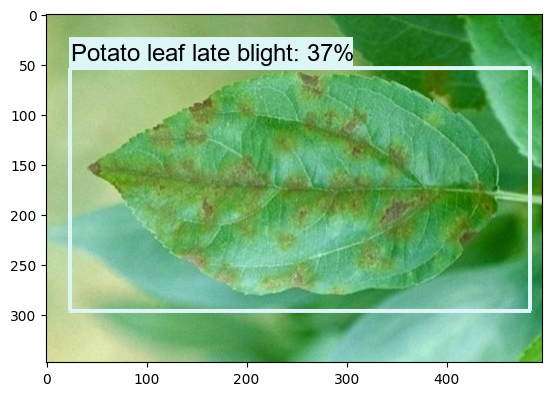

Squash Powdery mildew leaf 0.2819689
Potato leaf early blight 0.2624669
Tomato leaf bacterial spot 0.25837588
ACTUAL:  Apple rust leaf


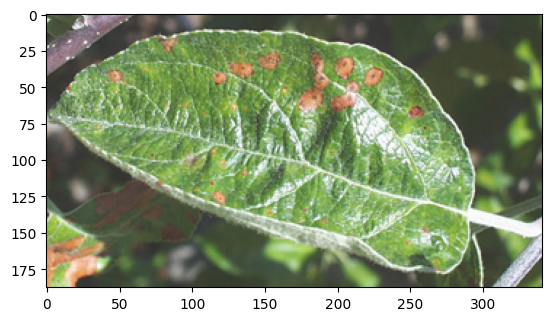

Corn leaf blight 0.42691073
Corn leaf blight 0.35638165
Corn leaf blight 0.2829905
ACTUAL:  Tomato leaf bacterial spot


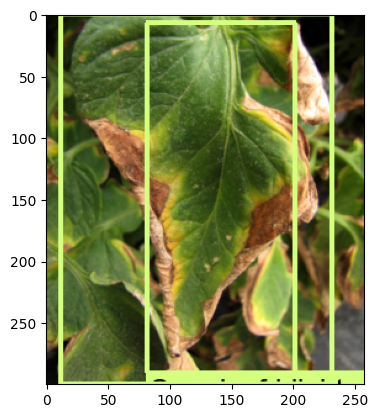

Corn Gray leaf spot 0.40063784
Corn leaf blight 0.32965335
Corn rust leaf 0.32215667
ACTUAL:  Corn leaf blight


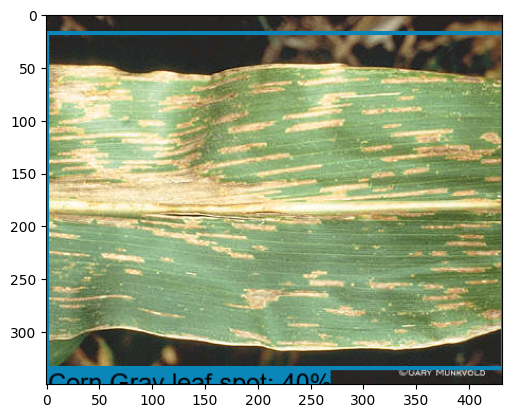

Corn leaf blight 0.5985042
Corn Gray leaf spot 0.4658323
Corn rust leaf 0.37571776
ACTUAL:  Corn rust leaf


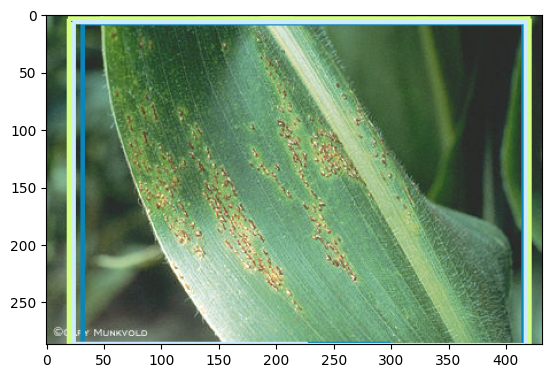

Corn Gray leaf spot 0.2793176
Potato leaf early blight 0.24721919
grape leaf black rot 0.21887809
ACTUAL:  Corn rust leaf


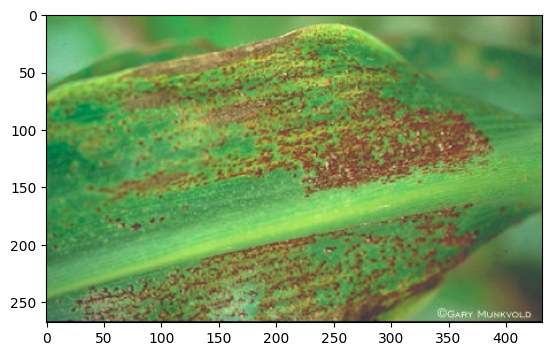

Squash Powdery mildew leaf 0.3767089
Corn leaf blight 0.2836311
Corn rust leaf 0.25953507
ACTUAL:  Corn rust leaf


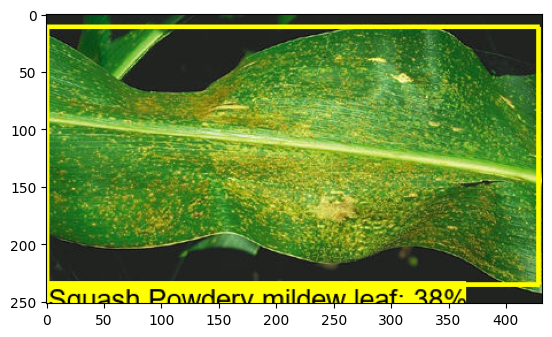

Corn Gray leaf spot 0.33932725
Corn rust leaf 0.27338803
Corn leaf blight 0.25738367
ACTUAL:  Corn rust leaf


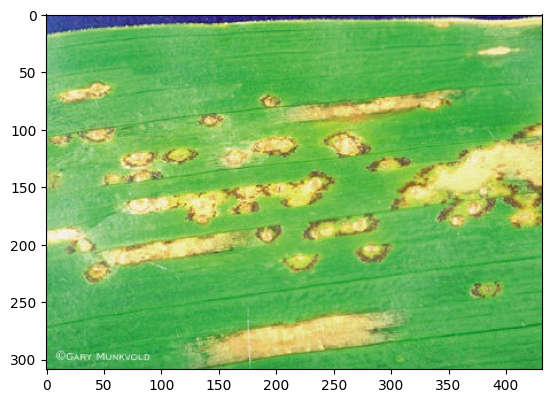

Corn leaf blight 0.49950588
Corn Gray leaf spot 0.41203463
Corn rust leaf 0.33301657
ACTUAL:  Corn leaf blight


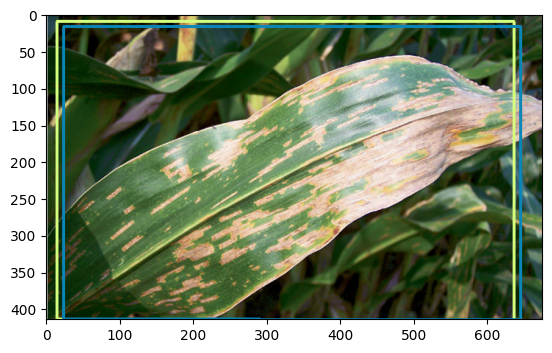

Soyabean leaf 0.52757657
Potato leaf late blight 0.4329402
Raspberry leaf 0.39153036
ACTUAL:  Soyabean leaf


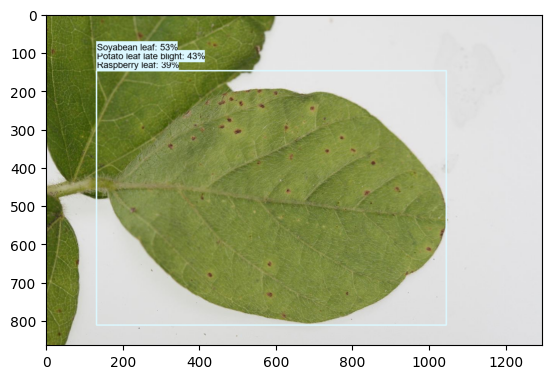

In [27]:
testfiles = os.listdir(os.path.join(paths['IMAGE_PATH'], 'TEST'))
testfiles = [t for t in testfiles if t[-4:]=='.jpg']

for f in testfiles[10:20]:
    predict_one_image(os.path.join(paths['IMAGE_PATH'], 'TEST', f))

# 10. Freezing the Graph / export protobuf

In [28]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [29]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [30]:
print(command)

python Tensorflow\models\research\object_detection\exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=Tensorflow\workspace\models\my_resnet101fpn\pipeline.config --trained_checkpoint_dir=Tensorflow\workspace\models\my_resnet101fpn --output_directory=Tensorflow\workspace\models\my_resnet101fpn\export


In [31]:
!{command}

2022-09-28 04:52:14.568853: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-28 04:52:14.951064: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2734 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0928 04:52:15.687717 21216 deprecation.py:623] From c:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\autograph\impl\api.py:458: calling map_fn_v2 (

## To check if saved model can be deployed in tf serving. apparently there is an issue/bug listed below: 
- (Save model as protobuf)(apparently bug in current exporter.py)(I've not looked into it yet)

- ref: https://medium.com/innovation-machine/deploying-object-detection-model-with-tensorflow-serving-7f12ee59b036
- "Checkpoint files can be used for inference directly or we can use freeze_graph.py script to convert the model into a frozen graph consisting of the model architecture and weights in one file. This is useful for testing purposes on your local machine but not suitable for a production environment. To create models ready for serving, we will tweak the exporter.py file available on the object detection API Github. The original script available on the repo does not save the Variables that are required for serving. Use the following exporter.py script instead of the original TensorFlow one."

In [ ]:
%%writefile modelexporter.py
# Copyright 2017 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Functions to export object detection inference graph."""
import logging
import os
import tempfile
import tensorflow as tf
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.python import pywrap_tensorflow
from tensorflow.python.client import session
from tensorflow.python.framework import graph_util
from tensorflow.python.platform import gfile
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.training import saver as saver_lib
from object_detection.builders import model_builder
from object_detection.core import standard_fields as fields
from object_detection.data_decoders import tf_example_decoder

slim = tf.contrib.slim


# TODO: Replace with freeze_graph.freeze_graph_with_def_protos when
# newer version of Tensorflow becomes more common.
def freeze_graph_with_def_protos(
    input_graph_def,
    input_saver_def,
    input_checkpoint,
    output_node_names,
    restore_op_name,
    filename_tensor_name,
    clear_devices,
    initializer_nodes,
    optimize_graph=True,
    variable_names_blacklist=''):
  """Converts all variables in a graph and checkpoint into constants."""
  del restore_op_name, filename_tensor_name  # Unused by updated loading code.

  # 'input_checkpoint' may be a prefix if we're using Saver V2 format
  if not saver_lib.checkpoint_exists(input_checkpoint):
    raise ValueError(
        'Input checkpoint "' + input_checkpoint + '" does not exist!')

  if not output_node_names:
    raise ValueError(
        'You must supply the name of a node to --output_node_names.')

  # Remove all the explicit device specifications for this node. This helps to
  # make the graph more portable.
  if clear_devices:
    for node in input_graph_def.node:
      node.device = ''

  with tf.Graph().as_default():
    tf.import_graph_def(input_graph_def, name='')

    if optimize_graph:
      logging.info('Graph Rewriter optimizations enabled')
      rewrite_options = rewriter_config_pb2.RewriterConfig(
          optimize_tensor_layout=True)
      rewrite_options.optimizers.append('pruning')
      rewrite_options.optimizers.append('constfold')
      rewrite_options.optimizers.append('layout')
      graph_options = tf.GraphOptions(
          rewrite_options=rewrite_options, infer_shapes=True)
    else:
      logging.info('Graph Rewriter optimizations disabled')
      graph_options = tf.GraphOptions()
    config = tf.ConfigProto(graph_options=graph_options)
    with session.Session(config=config) as sess:
      if input_saver_def:
        saver = saver_lib.Saver(saver_def=input_saver_def)
        saver.restore(sess, input_checkpoint)
      else:
        var_list = {}
        reader = pywrap_tensorflow.NewCheckpointReader(input_checkpoint)
        var_to_shape_map = reader.get_variable_to_shape_map()
        for key in var_to_shape_map:
          try:
            tensor = sess.graph.get_tensor_by_name(key + ':0')
          except KeyError:
            # This tensor doesn't exist in the graph (for example it's
            # 'global_step' or a similar housekeeping element) so skip it.
            continue
          var_list[key] = tensor
        saver = saver_lib.Saver(var_list=var_list)
        saver.restore(sess, input_checkpoint)
        if initializer_nodes:
          sess.run(initializer_nodes)

      variable_names_blacklist = (variable_names_blacklist.split(',') if
                                  variable_names_blacklist else None)
      output_graph_def = graph_util.convert_variables_to_constants(
          sess,
          input_graph_def,
          output_node_names.split(','),
          variable_names_blacklist=variable_names_blacklist)

  return output_graph_def


def replace_variable_values_with_moving_averages(graph,
                                                 current_checkpoint_file,
                                                 new_checkpoint_file):
  """Replaces variable values in the checkpoint with their moving averages.
  If the current checkpoint has shadow variables maintaining moving averages of
  the variables defined in the graph, this function generates a new checkpoint
  where the variables contain the values of their moving averages.
  Args:
    graph: a tf.Graph object.
    current_checkpoint_file: a checkpoint containing both original variables and
      their moving averages.
    new_checkpoint_file: file path to write a new checkpoint.
  """
  with graph.as_default():
    variable_averages = tf.train.ExponentialMovingAverage(0.0)
    ema_variables_to_restore = variable_averages.variables_to_restore()
    with tf.Session() as sess:
      read_saver = tf.train.Saver(ema_variables_to_restore)
      read_saver.restore(sess, current_checkpoint_file)
      write_saver = tf.train.Saver()
      write_saver.save(sess, new_checkpoint_file)


def _image_tensor_input_placeholder(input_shape=None):
  """Returns input placeholder and a 4-D uint8 image tensor."""
  if input_shape is None:
    input_shape = (None, None, None, 3)
  input_tensor = tf.placeholder(
      dtype=tf.uint8, shape=input_shape, name='image_tensor')
  return input_tensor, input_tensor


def _tf_example_input_placeholder():
  """Returns input that accepts a batch of strings with tf examples.
  Returns:
    a tuple of input placeholder and the output decoded images.
  """
  batch_tf_example_placeholder = tf.placeholder(
      tf.string, shape=[None], name='tf_example')
  def decode(tf_example_string_tensor):
    tensor_dict = tf_example_decoder.TfExampleDecoder().decode(
        tf_example_string_tensor)
    image_tensor = tensor_dict[fields.InputDataFields.image]
    return image_tensor
  return (batch_tf_example_placeholder,
          tf.map_fn(decode,
                    elems=batch_tf_example_placeholder,
                    dtype=tf.uint8,
                    parallel_iterations=32,
                    back_prop=False))


def _encoded_image_string_tensor_input_placeholder():
  """Returns input that accepts a batch of PNG or JPEG strings.
  Returns:
    a tuple of input placeholder and the output decoded images.
  """
  batch_image_str_placeholder = tf.placeholder(
      dtype=tf.string,
      shape=[None],
      name='encoded_image_string_tensor')
  def decode(encoded_image_string_tensor):
    image_tensor = tf.image.decode_image(encoded_image_string_tensor,
                                         channels=3)
    image_tensor.set_shape((None, None, 3))
    return image_tensor
  return (batch_image_str_placeholder,
          tf.map_fn(
              decode,
              elems=batch_image_str_placeholder,
              dtype=tf.uint8,
              parallel_iterations=32,
              back_prop=False))


input_placeholder_fn_map = {
    'image_tensor': _image_tensor_input_placeholder,
    'encoded_image_string_tensor':
    _encoded_image_string_tensor_input_placeholder,
    'tf_example': _tf_example_input_placeholder,
}


def _add_output_tensor_nodes(postprocessed_tensors,
                             output_collection_name='inference_op'):
  """Adds output nodes for detection boxes and scores.
  Adds the following nodes for output tensors -
    * num_detections: float32 tensor of shape [batch_size].
    * detection_boxes: float32 tensor of shape [batch_size, num_boxes, 4]
      containing detected boxes.
    * detection_scores: float32 tensor of shape [batch_size, num_boxes]
      containing scores for the detected boxes.
    * detection_classes: float32 tensor of shape [batch_size, num_boxes]
      containing class predictions for the detected boxes.
    * detection_masks: (Optional) float32 tensor of shape
      [batch_size, num_boxes, mask_height, mask_width] containing masks for each
      detection box.
  Args:
    postprocessed_tensors: a dictionary containing the following fields
      'detection_boxes': [batch, max_detections, 4]
      'detection_scores': [batch, max_detections]
      'detection_classes': [batch, max_detections]
      'detection_masks': [batch, max_detections, mask_height, mask_width]
        (optional).
      'num_detections': [batch]
    output_collection_name: Name of collection to add output tensors to.
  Returns:
    A tensor dict containing the added output tensor nodes.
  """
  label_id_offset = 1
  boxes = postprocessed_tensors.get('detection_boxes')
  scores = postprocessed_tensors.get('detection_scores')
  classes = postprocessed_tensors.get('detection_classes') + label_id_offset
  masks = postprocessed_tensors.get('detection_masks')
  num_detections = postprocessed_tensors.get('num_detections')
  outputs = {}
  outputs['detection_boxes'] = tf.identity(boxes, name='detection_boxes')
  outputs['detection_scores'] = tf.identity(scores, name='detection_scores')
  outputs['detection_classes'] = tf.identity(classes, name='detection_classes')
  outputs['num_detections'] = tf.identity(num_detections, name='num_detections')
  if masks is not None:
    outputs['detection_masks'] = tf.identity(masks, name='detection_masks')
  for output_key in outputs:
    tf.add_to_collection(output_collection_name, outputs[output_key])
  if masks is not None:
    tf.add_to_collection(output_collection_name, outputs['detection_masks'])
  return outputs


# def _write_frozen_graph(frozen_graph_path, frozen_graph_def):
#   """Writes frozen graph to disk.
#
#   Args:
#     frozen_graph_path: Path to write inference graph.
#     frozen_graph_def: tf.GraphDef holding frozen graph.
#   """
#   with gfile.GFile(frozen_graph_path, 'wb') as f:
#     f.write(frozen_graph_def.SerializeToString())
#   logging.info('%d ops in the final graph.', len(frozen_graph_def.node))

def _write_saved_model(saved_model_path,
                       trained_checkpoint_prefix,
                       inputs,
                       outputs):
  """Writes SavedModel to disk.
  Args:
    saved_model_path: Path to write SavedModel.
    trained_checkpoint_prefix: path to trained_checkpoint_prefix.
    inputs: The input image tensor to use for detection.
    outputs: A tensor dictionary containing the outputs of a DetectionModel.
  """
  saver = tf.train.Saver()
  with session.Session() as sess:
    saver.restore(sess, trained_checkpoint_prefix)
    builder = tf.saved_model.builder.SavedModelBuilder(saved_model_path)

    tensor_info_inputs = {
          'inputs': tf.saved_model.utils.build_tensor_info(inputs)}
    tensor_info_outputs = {}
    for k, v in outputs.items():
      tensor_info_outputs[k] = tf.saved_model.utils.build_tensor_info(v)

    detection_signature = (
        tf.saved_model.signature_def_utils.build_signature_def(
              inputs=tensor_info_inputs,
              outputs=tensor_info_outputs,
              method_name=signature_constants.PREDICT_METHOD_NAME))

    builder.add_meta_graph_and_variables(
          sess, [tf.saved_model.tag_constants.SERVING],
          signature_def_map={
              'detection_signature':
                  detection_signature,
              signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
                  detection_signature,
          },
      )
    builder.save()

def _export_inference_graph(input_type,
                            detection_model,
                            use_moving_averages,
                            trained_checkpoint_prefix,
                            output_directory,
                            additional_output_tensor_names=None,
                            input_shape=None,
                            optimize_graph=True,
                            output_collection_name='inference_op'):
  """Export helper."""
  #tf.gfile.MakeDirs(output_directory)
  #frozen_graph_path = os.path.join(output_directory,
  #                                 'frozen_inference_graph.pb')
  #saved_model_path = os.path.join(output_directory, 'saved_model')
  saved_model_path = output_directory

  if input_type not in input_placeholder_fn_map:
    raise ValueError('Unknown input type: {}'.format(input_type))
  placeholder_args = {}
  if input_shape is not None:
    if input_type != 'image_tensor':
      raise ValueError('Can only specify input shape for `image_tensor` '
                       'inputs.')
    placeholder_args['input_shape'] = input_shape
  placeholder_tensor, input_tensors = input_placeholder_fn_map[input_type](
      **placeholder_args)
  inputs = tf.to_float(input_tensors)
  preprocessed_inputs = detection_model.preprocess(inputs)
  output_tensors = detection_model.predict(preprocessed_inputs)
  postprocessed_tensors = detection_model.postprocess(output_tensors)
  outputs = _add_output_tensor_nodes(postprocessed_tensors,
                                     output_collection_name)
  # Add global step to the graph.
  slim.get_or_create_global_step()

  if use_moving_averages:
    temp_checkpoint_file = tempfile.NamedTemporaryFile()
    replace_variable_values_with_moving_averages(
        tf.get_default_graph(), trained_checkpoint_prefix,
        temp_checkpoint_file.name)
    checkpoint_to_use = temp_checkpoint_file.name
  else:
    checkpoint_to_use = trained_checkpoint_prefix

  saver = tf.train.Saver()
  input_saver_def = saver.as_saver_def()

  if additional_output_tensor_names is not None:
    output_node_names = ','.join(outputs.keys()+additional_output_tensor_names)
  else:
    output_node_names = ','.join(outputs.keys())

  frozen_graph_def = freeze_graph_with_def_protos(
      input_graph_def=tf.get_default_graph().as_graph_def(),
      input_saver_def=input_saver_def,
      input_checkpoint=checkpoint_to_use,
      output_node_names=output_node_names,
      restore_op_name='save/restore_all',
      filename_tensor_name='save/Const:0',
      clear_devices=True,
      optimize_graph=optimize_graph,
      initializer_nodes='')
  #_write_frozen_graph(frozen_graph_path, frozen_graph_def)
  _write_saved_model(saved_model_path, trained_checkpoint_prefix,
                     placeholder_tensor, outputs)


def export_inference_graph(input_type,
                           pipeline_config,
                           trained_checkpoint_prefix,
                           output_directory,
                           input_shape=None,
                           optimize_graph=True,
                           output_collection_name='inference_op',
                           additional_output_tensor_names=None):
  """Exports inference graph for the model specified in the pipeline config.
  Args:
    input_type: Type of input for the graph. Can be one of [`image_tensor`,
      `tf_example`].
    pipeline_config: pipeline_pb2.TrainAndEvalPipelineConfig proto.
    trained_checkpoint_prefix: Path to the trained checkpoint file.
    output_directory: Path to write outputs.
    input_shape: Sets a fixed shape for an `image_tensor` input. If not
      specified, will default to [None, None, None, 3].
    optimize_graph: Whether to optimize graph using Grappler.
    output_collection_name: Name of collection to add output tensors to.
      If None, does not add output tensors to a collection.
    additional_output_tensor_names: list of additional output
    tensors to include in the frozen graph.
  """
  detection_model = model_builder.build(pipeline_config.model,
                                        is_training=False)
  _export_inference_graph(input_type, detection_model,
                          pipeline_config.eval_config.use_moving_averages,
                          trained_checkpoint_prefix,
                          output_directory, additional_output_tensor_names,
                          input_shape, optimize_graph, output_collection_name)

Writing modelexporter.py


In [ ]:
import sys
sys.path.append(os.getcwd())
# from modelexporter import export_inference_graph
import modelexporter

ModuleNotFoundError: No module named 'modelexporter'

In [ ]:
import tensorflow as tf
impo

# Assuming object detection API is available for use
from object_detection.utils.config_util import create_pipeline_proto_from_configs
from object_detection.utils.config_util import get_configs_from_pipeline_file
import object_detection.exporter

# Configuration for model to be exported
config_pathname = files['PIPELINE_CONFIG']

# Input checkpoint for the model to be exported
# Path to the directory which consists of the saved model on disk (see above)
trained_model_dir = paths['CHECKPOINT_PATH'] # os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')

# Create proto from model confguration
configs = get_configs_from_pipeline_file(config_pathname)
pipeline_proto = create_pipeline_proto_from_configs(configs=configs)

# Read .ckpt and .meta files from model directory
checkpoint = tf.train.get_checkpoint_state(trained_model_dir)
input_checkpoint = checkpoint.model_checkpoint_path

# Model Version
model_version_id = 'v1'

# Output Directory
output_directory = './Tensorflow/workspace/savedmodels/' + str(model_version_id)

# Export model for serving
object_detection.exporter.export_inference_graph(input_type='image_tensor',pipeline_config=pipeline_proto,trained_checkpoint_prefix=input_checkpoint,output_directory=output_directory)

RuntimeError: tf.placeholder() is not compatible with eager execution.

In [ ]:
detection_model

In [ ]:
import time

def export_model(model, base_path='./Tensorflow/workspace/savedmodels/'):
    path = os.path.join(base_path, str(int(time.time())))
    tf.saved_model.save(model, path)

export_model(ckpt)

# 10.2 TF Serving + Docker Deployment

    docker run -p 8500:8500 -p 8501:8501 --mount type=bind,source=D:/code/_projects/_practice/TFODCourse-main/Tensorflow/workspace/savedmodels,target=/models/plantdoc -e MODEL_NAME=plantdoc -t tensorflow/serving:2.8.0

# 11. Conversion to TFJS

In [ ]:
!pip install tensorflowjs

In [ ]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

# 12. Conversion to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
print(command)

In [ ]:
!{command}

# 13. Zip and Export Models 

In [ ]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')